# Problem Set 3

In [78]:
#Let there be np.light
import numpy as np
import pylab as plt
import pickle as pkl
import csv
import scipy.optimize, scipy.interpolate

## Problem 1

In [163]:
#Extracting data
with open("data1.csv","r") as csvfile:
    data_object = csv.reader(csvfile)
    data1 = np.array(list(data_object)).astype("float64")
    x_vals = data1[:,0]
    y_vals = data1[:,1]
    sigma_vals = data1[:,2]

#Outlier-trimmed data
x_vals_cut = data1[4:,0]
y_vals_cut = data1[4:,1]
sigma_vals_cut = data1[4:,2]

In [164]:
#Defining some functions
const = lambda x : 1
identity = lambda x : x
square = lambda x: x**2

#Constructing fitter
def designfit(x_array,y_array,sigma_array,*design):
    N = len(design) #number of variational parameters
    
    #Creating (transposed) design matrix
    A = [model(x_array) for model in design]
    
    #Creating the NxN inverse covariance matrix
    M_x = np.array([[np.sum(A[i]*sigma_array**(-2)*A[j]) for j in range(N)] for i in range(N)])
    
    #Creating the Nx1 M_y ordinate vector
    M_y = np.array([np.sum(A[i]*sigma_array**(-2)*y_array) for i in range(N)])
    
    #Solving for fit parameters. 
    return (np.linalg.solve(M_x,M_y))

#Constructing covariant matrix eigensystem extractor
def cov_eig(x_array,sigma_array,*design):
    N = len(design) #number of variational parameters
    
    #Creating (transposed) design matrix
    A = [model(x_array) for model in design]
    
    #Creating the NxN inverse covariance matrix
    cov_inv = np.array([[np.sum(A[i]*sigma_array**(-2)*A[j]) for j in range(N)] for i in range(N)])
    
    #Solving eigensystem
    output = np.linalg.eig(cov_inv)
    
    #Inverting eigenvalues
    for i in range(len(output[0])):
        output[0][i] = 1/output[0][i]
    
    return output

#Constructing ellipse extractor
def ellipse(cov_eig_input):
    eigvals = cov_eig_input[0]
    eigvecs = cov_eig_input[1]
    
    #Reorienting eigenvectors   
    for i in range(len(eigvecs)):
        if eigvecs[i,1] == 0:
            if eigvecs[i,0] < 0:
                eigvecs[i] = -eigvecs[i]
            else:
                None
        else:
            while eigvecs[i,1] < 0:
                eigvecs[i] = -eigvecs[i]
                
    #Sorting eigenvalues
    eigvals = eigvals[np.argsort(eigvecs[:,0])][::-1] 
    
    #Getting tilt of ellipse from ellipse
    eigvecs_sum = np.sum(eigvecs,0)
    theta = np.arctan2(eigvecs_sum[1],eigvecs_sum[0])
    
    return eigvals, theta

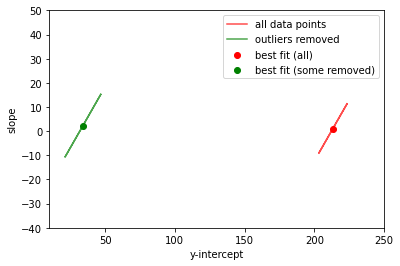

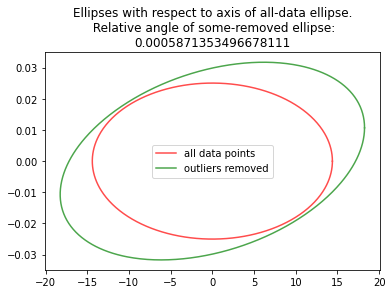

In [165]:
all_fit = tuple(designfit(x_vals,y_vals,sigma_vals,const,identity))
some_fit = tuple(designfit(x_vals_cut,y_vals_cut,sigma_vals_cut,const,identity))

all_ellipse = ellipse(cov_eig(x_vals,sigma_vals,const,identity))
some_ellipse = ellipse(cov_eig(x_vals_cut,sigma_vals_cut,const,identity))

all_eigx = np.sqrt(all_ellipse[0][0])
all_eigy = np.sqrt(all_ellipse[0][1])
all_tilt = all_ellipse[1]

some_eigx = np.sqrt(some_ellipse[0][0])
some_eigy = np.sqrt(some_ellipse[0][1])
some_tilt = some_ellipse[1]

#Plotting ellipse
ell_x = lambda t, tilt, x_sc, y_sc :  x_sc*np.cos(t)*np.cos(tilt) - y_sc*np.sin(t)*np.sin(tilt)
ell_y = lambda t, tilt, x_sc, y_sc :  x_sc*np.cos(t)*np.sin(tilt) + y_sc*np.sin(t)*np.cos(tilt)
rotate2D = lambda vec, theta : (vec[0]*np.cos(theta) - vec[1]*np.sin(theta), vec[0]*np.sin(theta) + vec[1]*np.cos(theta))

all_ell_x_points = ell_x(np.arange(0,2*np.pi,0.01),all_tilt,all_eigx,all_eigy) + all_fit[0]
all_ell_y_points = ell_y(np.arange(0,2*np.pi,0.01),all_tilt,all_eigx,all_eigy) + all_fit[1]
some_ell_x_points = ell_x(np.arange(0,2*np.pi,0.01),some_tilt,some_eigx,some_eigy) + some_fit[0]
some_ell_y_points = ell_y(np.arange(0,2*np.pi,0.01),some_tilt,some_eigx,some_eigy) + some_fit[1]

plt.plot(all_ell_x_points,all_ell_y_points, color='red', alpha=0.7, label='all data points')
plt.plot(some_ell_x_points,some_ell_y_points, color='green', alpha=0.7, label="outliers removed")
plt.scatter(all_fit[0],all_fit[1], color='red', label='best fit (all)')
plt.scatter(some_fit[0],some_fit[1], color='green', label='best fit (some removed)')
plt.xlabel("y-intercept")
plt.ylabel("slope")
plt.legend()
plt.xlim(10,250)
plt.ylim(-40,50)
plt.show()

#Rotated and concentric ellipses
Rall_ell_x_points = ell_x(np.arange(0,2*np.pi,0.01),0,all_eigx,all_eigy)
Rall_ell_y_points = ell_y(np.arange(0,2*np.pi,0.01),0,all_eigx,all_eigy)
Rsome_ell_x_points = ell_x(np.arange(0,2*np.pi,0.01),some_tilt-all_tilt,some_eigx,some_eigy)
Rsome_ell_y_points = ell_y(np.arange(0,2*np.pi,0.01),some_tilt-all_tilt,some_eigx,some_eigy)

plt.plot(Rall_ell_x_points,Rall_ell_y_points, color='red', alpha=0.7, label='all data points')
plt.plot(Rsome_ell_x_points,Rsome_ell_y_points, color='green', alpha=0.7, label="outliers removed")
plt.title(f'Ellipses with respect to axis of all-data ellipse.\n Relative angle of some-removed ellipse:\n{some_tilt-all_tilt}')
plt.legend()
plt.show()

## Problem 2

In [74]:
#Extracting data
# Dear all: Get this pickle file from the discord server!
with open("data.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`

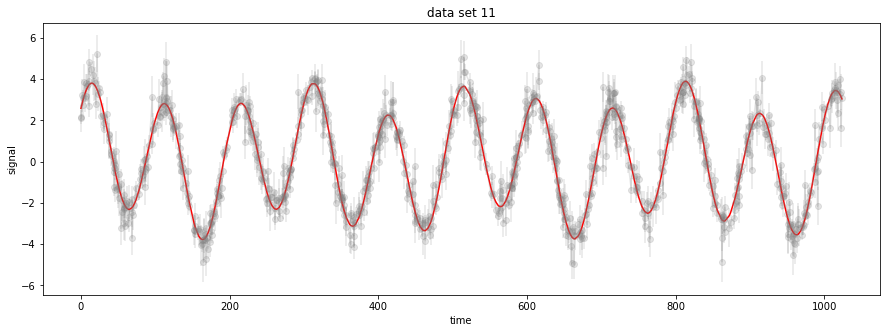

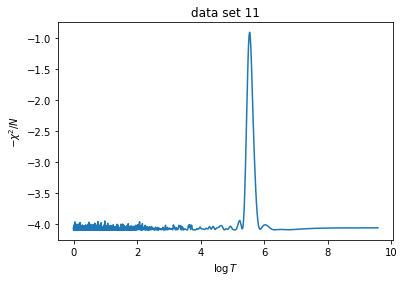

In [75]:
#Knobs
data_set_index = 12
sample_step = 0.07

#Defining some functions
identity = lambda x: 1
cos100 = lambda x : np.cos((2*np.pi/100)*x)
sin100 = lambda x : np.sin((2*np.pi/100)*x)

#Getting best-fits, chi-squared values, and plots
chisq2 = []

#Setting up log likelihood sample space
total_time = int(max(data[0])-min(data[0]))
freq_samples = np.arange(sample_step,total_time+sample_step,sample_step)/total_time
neg_chisq = []

#Exploring the parameter space
for f in freq_samples:
    sinvar = lambda x : np.sin(2*np.pi*f*x)
    cosvar = lambda x : np.cos(2*np.pi*f*x)

    par_vals2 = designfit(data[0],data[data_set_index],data[1],cos100,sin100,identity,cosvar,sinvar)

    y_pred_vals = par_vals2[0]*cos100(data[0]) + par_vals2[1]*sin100(data[0]) + par_vals2[2] + par_vals2[3]*cosvar(data[0]) + par_vals2[4]*sinvar(data[0])
    delta_y = data[data_set_index] - y_pred_vals
    neg_chisq.append(-np.sum(delta_y*data[1]**(-2)*delta_y))

#Setting initial guesses for parameter optimization
freq_best_guess = freq_samples[neg_chisq.index(max(neg_chisq))]
sinvarbest = lambda x : np.sin(2*np.pi*freq_best_guess*x)
cosvarbest = lambda x : np.cos(2*np.pi*freq_best_guess*x)
par_vals2_best_guess = designfit(data[0],data[data_set_index],data[1],cos100,sin100,identity,cosvarbest,sinvarbest)

#Defining functions
sinvarf = lambda x,f : np.sin(2*np.pi*f*x)
cosvarf = lambda x,f : np.cos(2*np.pi*f*x)
yfit_func = lambda x : x[0]*cos100(data[0]) + x[1]*sin100(data[0]) + x[2] + x[3]*cosvarf(data[0],x[5]) + x[4]*sinvarf(data[0],x[5])
chisq_func = lambda x : np.sum((data[data_set_index]-yfit_func(x))*data[1]**(-2)*(data[data_set_index]-yfit_func(x)))

#Initial guess for optimum parameter values
guess = np.array(list(par_vals2_best_guess) + [freq_best_guess])

#Getting best fit
bestfit_vals = scipy.optimize.minimize(chisq_func,guess,method='Nelder-Mead').x
y_bestfit_vals = yfit_func(bestfit_vals)

#Collecting chi-squared values
chisq2.append(np.sum((data[data_set_index]-y_bestfit_vals)*data[1]**(-2)*(data[data_set_index]-y_bestfit_vals)))

#Plotting
plt.figure(figsize=(15, 5))
plt.errorbar(data[0], data[data_set_index], yerr=data[1],
             color="gray", marker="o", alpha=0.2)
plt.plot(data[0],y_bestfit_vals,color='red')
plt.xlabel("time")
plt.ylabel("signal")
plt.title("data set {}".format(data_set_index-1))
plt.show()

plt.plot(-np.log(freq_samples),np.array(neg_chisq)/len(data[0]))
plt.ylabel('$-\chi^2/N$')
plt.xlabel('$\log T$')
plt.title(f'data set {data_set_index-1}')
plt.show()

# plt.plot(freq_samples**(-1),neg_chisq)
# plt.title('')
# plt.xlim(0,500)

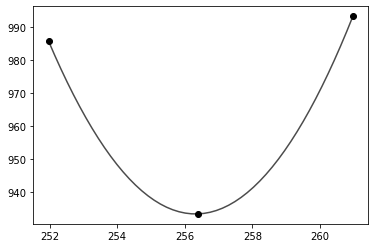

In [157]:
max_index = neg_chisq.index(max(neg_chisq))

parabola_sec_x = freq_samples[[max_index-1,max_index,max_index+1]]**(-1)
parabola_sec_y = -np.array(neg_chisq)[[max_index-1,max_index,max_index+1]]
parabola_pars = designfit(parabola_sec_x,parabola_sec_y,np.ones(3),const,identity,square)
parabola_x_fine = np.linspace(min(parabola_sec_x),max(parabola_sec_x))

plt.plot(parabola_x_fine, parabola_pars[0] + parabola_pars[1]*parabola_x_fine + parabola_pars[2]*parabola_x_fine**2, color='black', alpha=0.7)
plt.scatter(parabola_sec_x,parabola_sec_y, color='black')
plt.show()

In [162]:
#Standard uncertainty
(2*designfit(parabola_sec_x,parabola_sec_y,np.ones(3),const,identity,square)[2])**(-1/2)

0.42459025492674074

## Problem 3

In [96]:
#Defining Gaussian in 1D
gaussian1D = lambda x, mean, sigmasq : 1/np.sqrt(2*np.pi*sigmasq) * np.exp((-1/(2*sigmasq))*(x-mean)**2)

#Defining Gaussin in N dims
def gaussianND(x,mean,cov):
    centered = np.array(x)-np.array(mean)
    return 1/np.sqrt((2*np.pi)**(len(x))*np.linalg.det(cov)) * np.exp((-1/2)*np.matmul(centered,np.linalg.solve(np.array(cov),centered)))

#Constructing MHMCMC sampler in N dims
def mhmcmcND(f,x0,samples,prop_cov):
    output = [x0]
    current_x = x0
    
    for sample in range(samples-1):
        prop_x = np.random.multivariate_normal(current_x,prop_cov)
        
        if f(prop_x)/f(current_x) >= np.random.rand():
            current_x = prop_x
            
        output.append(current_x)
    
    return np.array(output)

**Problem 2**

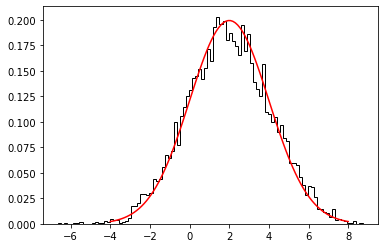

In [97]:
#PDF 1

pdf1 = lambda x : gaussianND(x,2,[[4]])
points = mhmcmcND(pdf1,[0],10000,[[1]])
plt.hist(points,density=True,bins=100,histtype='step',color='black')
plt.plot(np.linspace(-4,8,100),gaussian1D(np.linspace(-4,8,100),2,4),color='red')
plt.show()

**Problem 4**

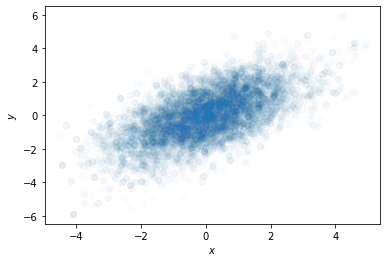

In [122]:
#PDF 2

cov_pdf2 = [[2.0,1.2],[1.2,2.0]]
pdf2 = lambda x : gaussianND(x,[0,0],cov_pdf2)

points2 = mhmcmcND(pdf2,[0.5,0.5],10000,[[1,0],[0,1]])
plt.scatter(points2[:,0],points2[:,1], alpha=0.02)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

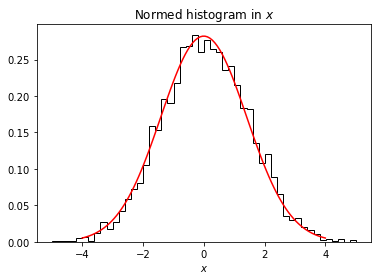

In [116]:
plt.hist(points2[:,0],density=True,bins=50,histtype='step',color='black')
plt.plot(np.linspace(-4,4,100),gaussian1D(np.linspace(-4,4,100),0,2),color='red')
plt.title('Normed histogram in $x$')
plt.xlabel('$x$')
plt.show()

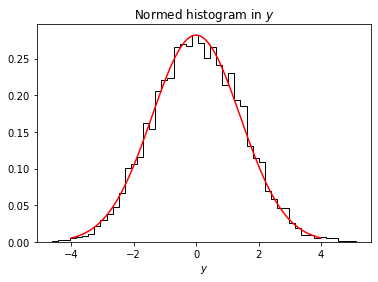

In [117]:
plt.hist(points2[:,1],density=True,bins=50,histtype='step',color='black')
plt.plot(np.linspace(-4,4,100),gaussian1D(np.linspace(-4,4,100),0,2),color='red')
plt.title('Normed histogram in $y$')
plt.xlabel('$y$')
plt.show()

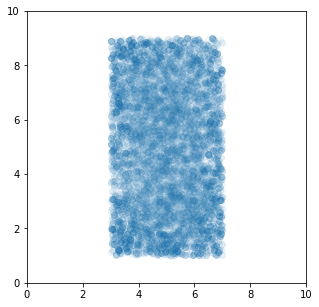

In [110]:
#PDF 3

def pdf3(x):
    if x[0]>3 and x[0]<7 and x[1]>1 and x[1]<9:
        return 1/32
    else:
        return 0

points3 = mhmcmcND(pdf3,[3.5,1.5],10000,[[1,0],[0,1]])
plt.figure(figsize=(5,5))
plt.scatter(points3[:,0],points3[:,1], alpha=0.05)
plt.xlim(0,10)
plt.ylim(0,10)
plt.show()

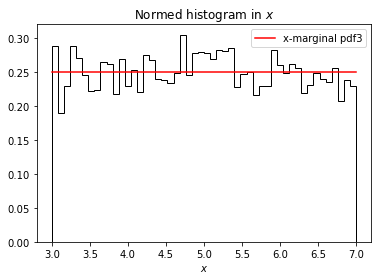

In [111]:
plt.hist(points3[:,0],density=True,bins=50,histtype='step',color='black')
plt.plot(np.linspace(3,7,100),1/4*np.ones(100),color='red',label='x-marginal pdf3')
plt.title('Normed histogram in $x$')
plt.xlabel('$x$')
plt.legend()
plt.show()

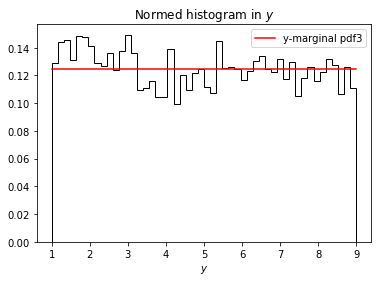

In [112]:
plt.hist(points3[:,1],density=True,bins=50,histtype='step',color='black')
plt.plot(np.linspace(1,9,100),1/8*np.ones(100),color='red',label='y-marginal pdf3')
plt.title('Normed histogram in $y$')
plt.xlabel('$y$')
plt.legend()
plt.show()

**Problem 10**

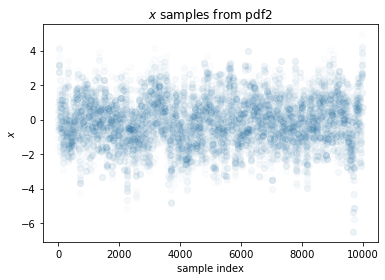

In [113]:
plt.plot(points2[:,0],'o',alpha=0.02)
plt.xlabel('sample index')
plt.ylabel('$x$')
plt.title('$x$ samples from pdf2')
plt.show()

In [123]:
x_chunks = np.split(points2[:,0],4)

print('(mean,variance) of x data segments from pdf2:')
for x_dataset in x_chunks:
    print(f'{np.mean(x_dataset)}, {np.var(x_dataset)}')

(mean,variance) of x data segments from pdf2:
-0.14556394787149926, 1.9180834429281175
0.24226239092419755, 1.9057091418514391
-0.10333715459483617, 1.9145338465175359
-0.06136131807849254, 2.1313791929392396
